In [ ]:
# Copyright (C) 2023 Elif Cansu YILDIZ
# 
# This program is free software; you can redistribute it and/or modify it under
# the terms of the GNU General Public License as published by the Free Software
# Foundation; either version 3 of the License, or (at your option) any later
# version.
# 
# This program is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE. See the GNU General Public License for more
# details.
# 
# You should have received a copy of the GNU General Public License along with
# this program; if not, see <http://www.gnu.org/licenses/>.

# ChestX-Det-Dataset

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
import json
import pickle
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from medai.utils.transforms import Resize
from PIL import Image
from matplotlib.path import Path
import seaborn as sns
import yaml
import os
import medai.config as config

from medai.data.loader import ChestDataModule
from medai.data.datasets import ChestXDetDataset
from medai.utils.visualizer import draw_polygons, draw_bounding_boxes, inspect_label, show_multilabel_images

%load_ext autoreload
%autoreload 2

In [2]:
config_file = "sasn_config.yaml"
config_file_path = os.path.join(config.CONFIG_DIR, config_file)
with open(config_file_path, "r") as stream:
    params = yaml.safe_load(stream)
    
dataset = ChestXDetDataset(**params["dataset"]["train"])
test_dataset = ChestXDetDataset(**params["dataset"]["test"])

In [3]:
def dataset_stats_table(dataset):
    num_bboxlabels_per_disease = dataset.num_of_all_labels_per_disease
    num_images_per_disease = dataset.num_of_unique_image_labels
    data_stats = {}

    for label in num_bboxlabels_per_disease:
        if label == "No Finding":
            continue
        data_stats[label] = []
        data_stats[label].append(num_bboxlabels_per_disease[label])
        data_stats[label].append(num_images_per_disease[label])
        
    index_labels=['number of annotations','number of images']
    df = pd.DataFrame(data_stats, index=index_labels)
    return df

In [4]:
df = dataset_stats_table(dataset)
#df.to_csv("csv_outputs/train_val_label_stats.csv")
df

,Nodule,Consolidation,Effusion,Pleural Thickening,Fibrosis,Emphysema,Calcification,Atelectasis,Pneumothorax,Mass,Diffuse Nodule
number of annotations,816,2110,1734,526,619,232,281,289,169,133,227
number of images,313,1349,1185,412,418,137,164,249,154,115,133


Labels only exist in CXR8: ["Infiltration","Pneumonia", "Edema", "Hernia",]  
Labels only exist in ChestXDetDataset: ["Calcification"   'Diffuse Nodule', "Fracture"]

In [5]:
df = dataset_stats_table(test_dataset)
#df.to_csv("csv_outputs/test_label_stats.csv")
df

,Effusion,Nodule,Fibrosis,Consolidation,Emphysema,Mass,Calcification,Pleural Thickening,Pneumothorax,Atelectasis,Diffuse Nodule
number of annotations,378,170,120,453,66,34,67,105,42,51,63
number of images,256,79,82,293,39,33,38,87,35,48,36


In [6]:
def train_test_dataset_stats_table(dataset, test_dataset):
    data_stats = {}
    labels = list(dataset.num_of_all_labels_per_disease.keys())[1:]

    for column, dataset in zip(["train data", "test data"], [dataset, test_dataset]):
        num_annotations_per_disease = dataset.num_of_all_labels_per_disease
        num_images_per_disease = dataset.num_of_unique_image_labels
        
        for name, numbers in zip(['number of annotations','number of images'], [num_annotations_per_disease, num_images_per_disease]):
            column_name = column + " " + name
            data_stats[column_name] = []
            
            for lbl in labels:
                if lbl == "No Finding":
                    continue

                data_stats[column_name].append(numbers[lbl])
        
    df = pd.DataFrame(data_stats, index=labels)
    return df

In [7]:
df = train_test_dataset_stats_table(dataset, test_dataset)
#df.to_csv("csv_outputs/train_val_label_stats.csv")
df

,train data number of annotations,train data number of images,test data number of annotations,test data number of images
Nodule,816,313,170,79
Consolidation,2110,1349,453,293
Effusion,1734,1185,378,256
Pleural Thickening,526,412,105,87
Fibrosis,619,418,120,82
Emphysema,232,137,66,39
Calcification,281,164,67,38
Atelectasis,289,249,51,48
Pneumothorax,169,154,42,35
Mass,133,115,34,33


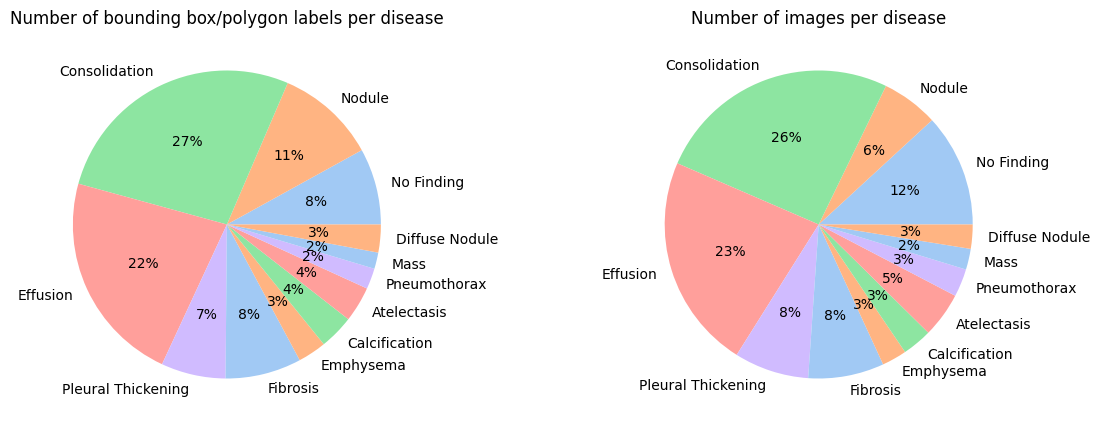

In [8]:
def dataset_stats_pie_chart(dataset):
    num_bboxlabels_per_disease = dataset.num_of_all_labels_per_disease
    num_images_per_disease = dataset.num_of_unique_image_labels
    
    fig, axs = plt.subplots(1,2, figsize= (14,5))

    #define Seaborn color palette to use
    colors = sns.color_palette('pastel')[0:5]
    #define data
    labels = num_bboxlabels_per_disease.keys()
    data = num_bboxlabels_per_disease.values()
    #create pie chart
    axs[0].pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    axs[0].set_title("Number of bounding box/polygon labels per disease")

    #define data
    labels = num_images_per_disease.keys()
    data = num_images_per_disease.values()
    #create pie chart
    axs[1].pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    axs[1].set_title("Number of images per disease")
    plt.show()
    
dataset_stats_pie_chart(dataset)

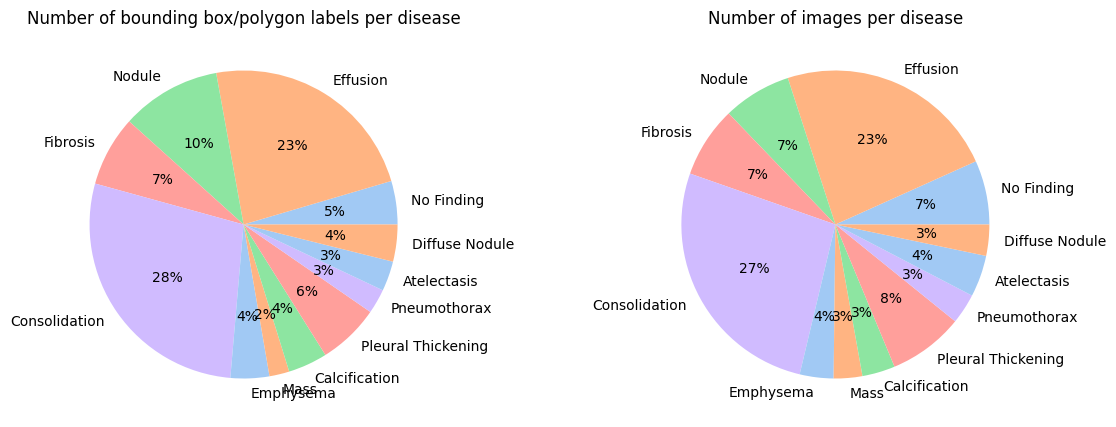

In [9]:
dataset_stats_pie_chart(test_dataset)

In [10]:
dataset = ChestXDetDataset(**params["dataset"]["train"])
test_dataset = ChestXDetDataset(**params["dataset"]["test"])

data_splits = {"Train/val": [dataset.num_binary_labels["Healthy"], dataset.num_binary_labels["Diseased"], (dataset.num_binary_labels["Healthy"] + dataset.num_binary_labels["Diseased"]) ],
            "Test": [test_dataset.num_binary_labels["Healthy"], test_dataset.num_binary_labels["Diseased"], (test_dataset.num_binary_labels["Healthy"] + test_dataset.num_binary_labels["Diseased"]) ],
            }
index_labels=['Healthy','Diseased', 'Total']
df = pd.DataFrame(data_splits, index=index_labels)
df

,Train/val,Test
Healthy,622,74
Diseased,2403,479
Total,3025,553


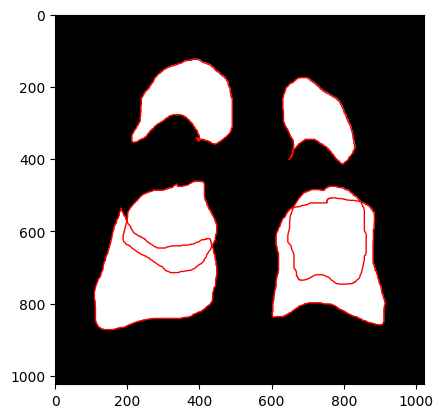

In [11]:
image, labels, encoded_label, bboxes, polygons, target_heatmap = dataset.data_reader(43)

fig, axs = plt.subplots(1,1)
axs.imshow(target_heatmap, cmap="gray")
for polygon in (polygons):
    p = Polygon(np.array(polygon), fill=False, color="red")
    axs.add_patch(p)

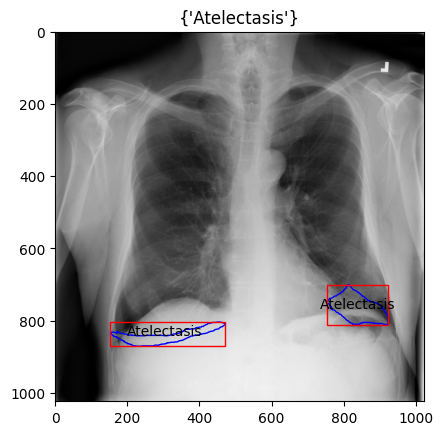

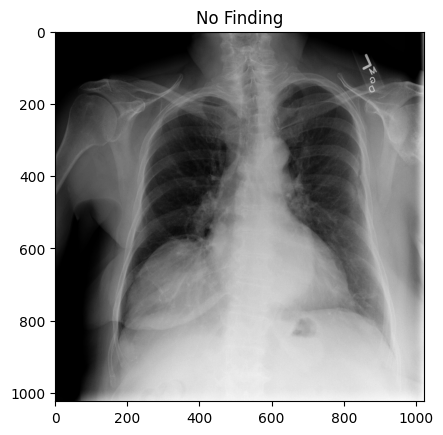

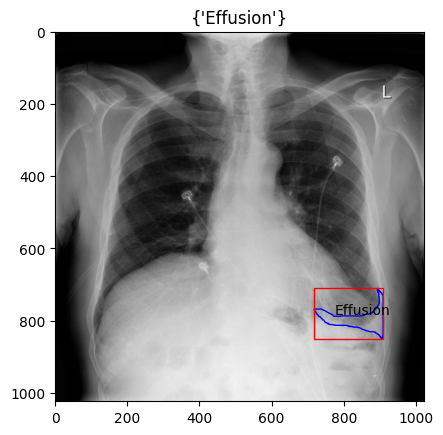

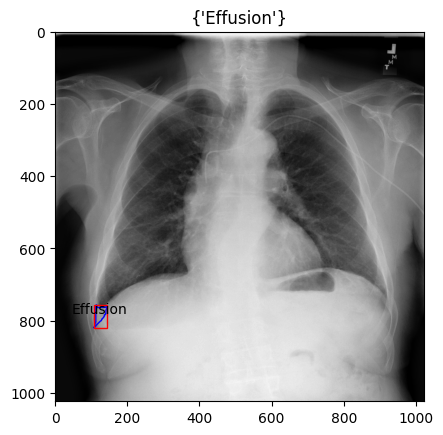

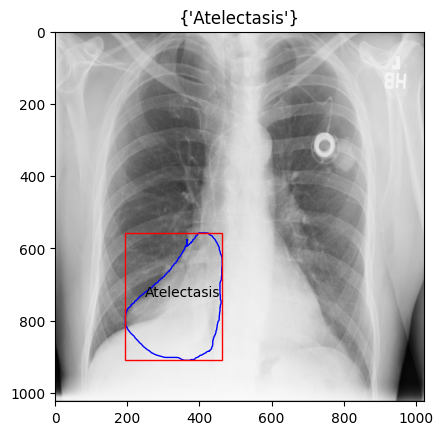

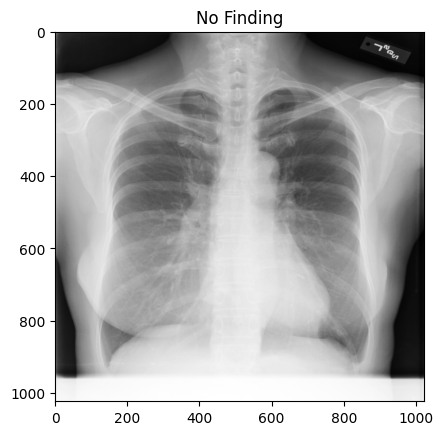

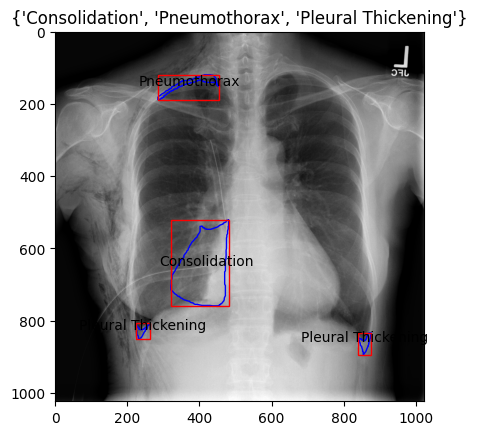

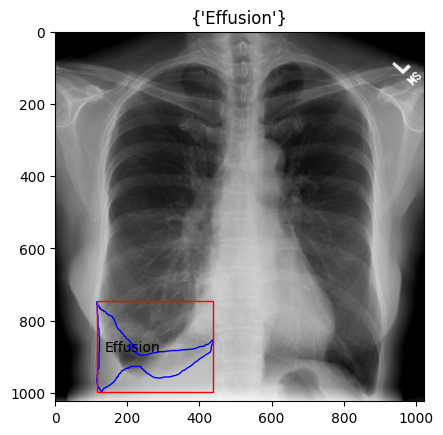

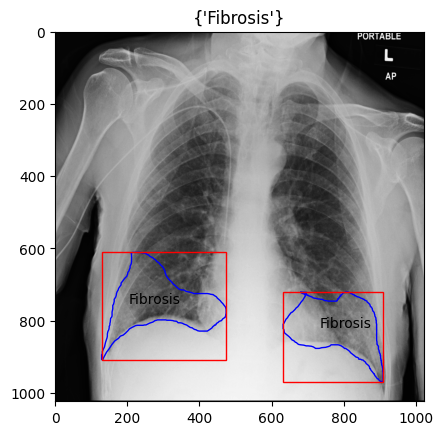

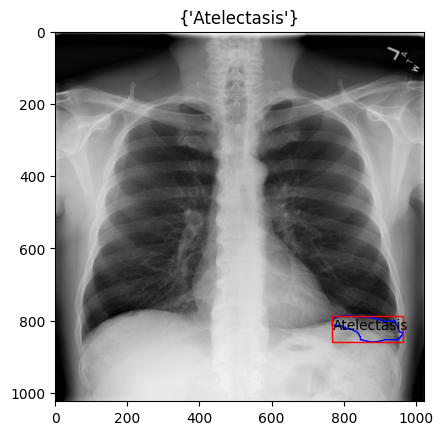

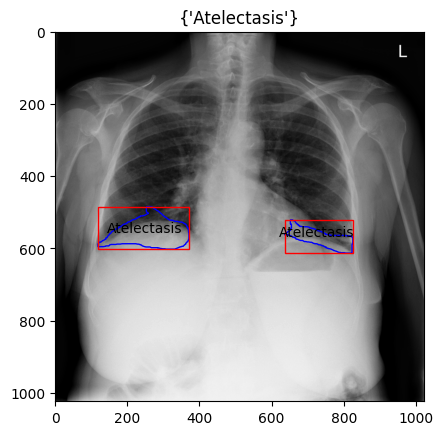

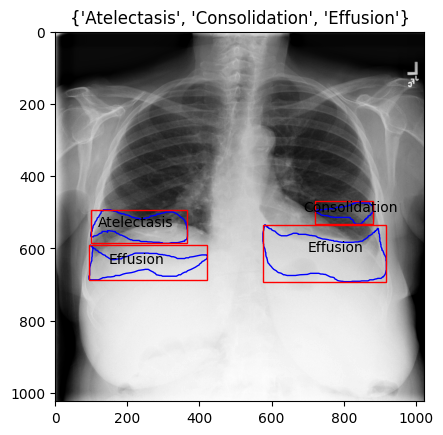

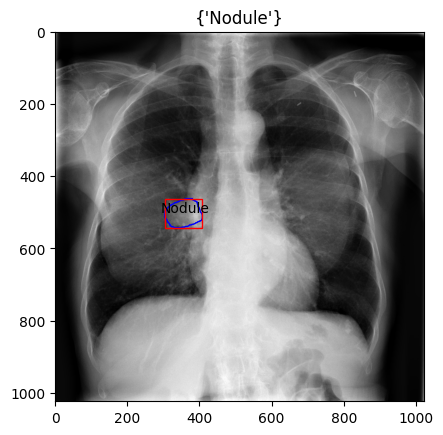

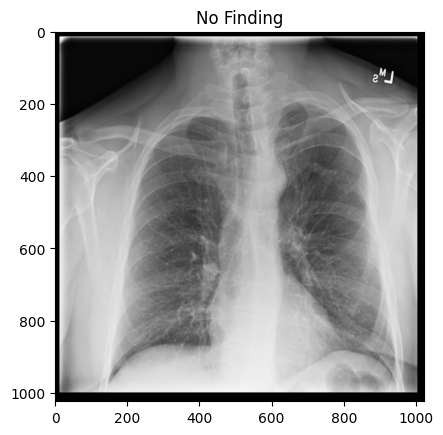

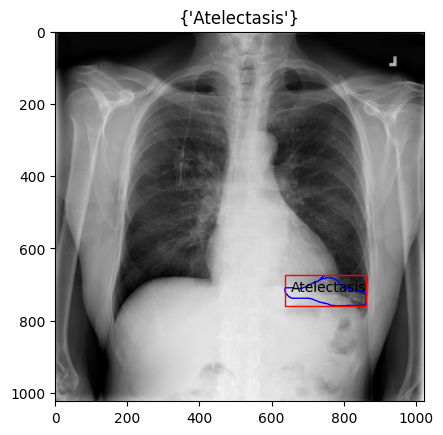

In [12]:
samples, axes = [], []
for i in range(20,35):
    samples.append(dataset.data_reader(i))
    fig, axs = plt.subplots(1,1)
    axes.append(axs)
    
draw_polygons(samples, axes)
draw_bounding_boxes(samples, axes)

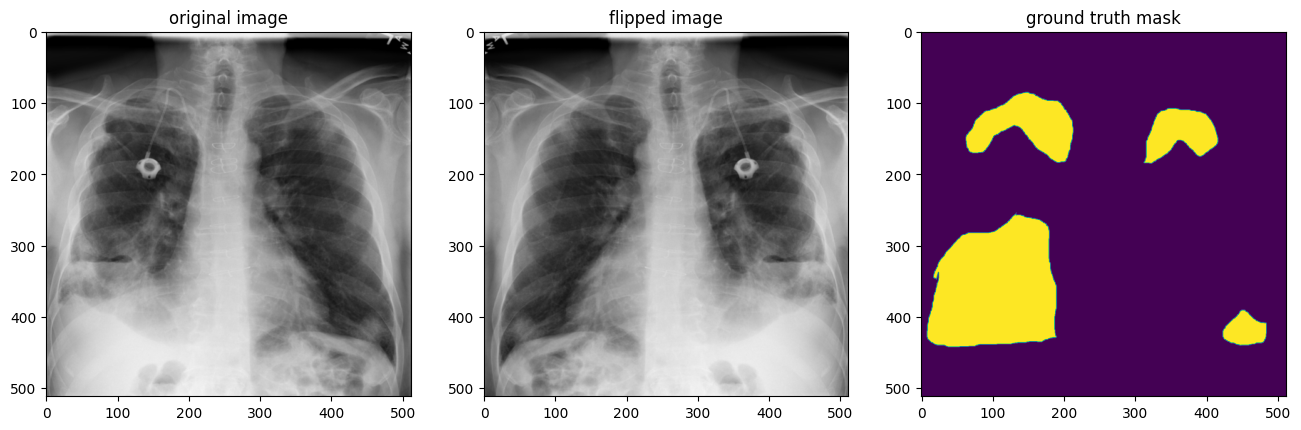

In [13]:
img, flipped_img, target_heatmap = dataset[42]
fig, axs = plt.subplots(1,3, figsize=(16,12))
_ = axs[0].imshow(img.permute(1,2,0));  _ = axs[0].set_title("original image")
_ = axs[1].imshow(flipped_img.permute(1,2,0));  _ = axs[1].set_title("flipped image")
_ = axs[2].imshow(target_heatmap.permute(1,2,0));  _ = axs[2].set_title("ground truth mask")

### To calculate the number of images including only the specified label

In [ ]:
data_module = ChestDataModule(dataset_class=ChestXDetDataset, **params["dataloader"])
data_module.setup("fit", **params["dataset"]["train"])

label_name = "Fracture"

counter = 0
for i in range(len(data_module.train_val_dataset)):
    image, labels, encoded_labels, bboxes, polygons, target_heatmap = data_module.train_val_dataset.data_reader(i)
    
    if len(set(labels)) == 1 and labels[0] == label_name:
        counter += 1
        print(labels)

print(counter)